# TOXIC COMMENT DETECTION PROJECT
## Deep Learning



In [ ]:
!pip install --upgrade matplotlib

In [ ]:
#installing required libraries
!pip install venn
!pip install contractions
!pip install scikit-multilearn

In [ ]:
#mandatory libraries
import os
import re
import string
import numpy as np
import pandas as pd

#plotting libraries
import venn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#NLTK libraries  & for data cleaning
import contractions
import nltk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

#sk-learn libraries for vectorization and TSNE
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
from itertools import combinations

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/train.csv'
df = pd.read_csv (path)

# EDA and Understanding Dataset

In [ ]:
#total dataset size
df.shape

(159571, 8)

In [ ]:
# Data overview on rows and columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Total Rows : 159571
Total Columns : 8

## Checking for Missing Values:


In [ ]:
#checking any null/nan present in dataset
df.isnull().values.any()


False

No Missing values detected.

## Checking for Duplicate entries:

In [ ]:
#checking if any duplicate entries exists.
df.duplicated().values.any()

False

No duplicate entries found

##Basic Statistics:

In [ ]:
# basic statistics like mean, standard deviation, and percentiles
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Finding from the above statistics:

- No values are missing from any columns
- No mean, std, 25th,50th,75th percentiles are calculated for ID and comment_text columns as its under object type.


# Viewing the Raw data

In [ ]:
# first 5 data entries
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# random 10-data entries
df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
63798,aab7a21ed912a22f,New page? \n\nThe Radio Control Software secti...,0,0,0,0,0,0
7206,1332cdbeede55027,"""\n Stop with the false unblock notices \n\nPu...",1,0,0,0,0,0
62476,a7311ed3cb2e41df,"""{| style=""""background-color:#F5FFFA; padding:...",0,0,0,0,0,0
7380,139e6b575ca46535,There is also a news article that indicates pe...,0,0,0,0,0,0
110229,4d9d4f99b016cc8a,CheckUser\n\nCan you do it? sock of User:Blurb...,0,0,0,0,0,0
28187,4aa175bcfc04f39f,"Are you naughty or nice? If nice, then you nev...",0,0,0,0,0,0
55026,930d01e7f9ebd23e,"Joined wikipedia \n\nHey, I just joined wikipe...",0,0,0,0,0,0
61608,a4e9c8328b080126,Could you please comment on rare earth mineral...,0,0,0,0,0,0
155178,ba22dac7677db675,4. Eva Longoria \nShe graduated from Texas A&M...,0,0,0,0,0,0
85766,e5685aa724f24222,TO THE BITTER END ! ! !,0,0,0,0,0,0


Obsevation from the Raw dataset samples:
- It containt many new line characters ("\n")
- Punctuation marks
- Upper case letters
- Short form text

Which we need to clean for vectorization process.

# Check Value count on each individual label

In [ ]:
# checking the value counts for each targets individually

for i in df.columns.values[2:]:
    print(df[i].value_counts())
    print("="*50)

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


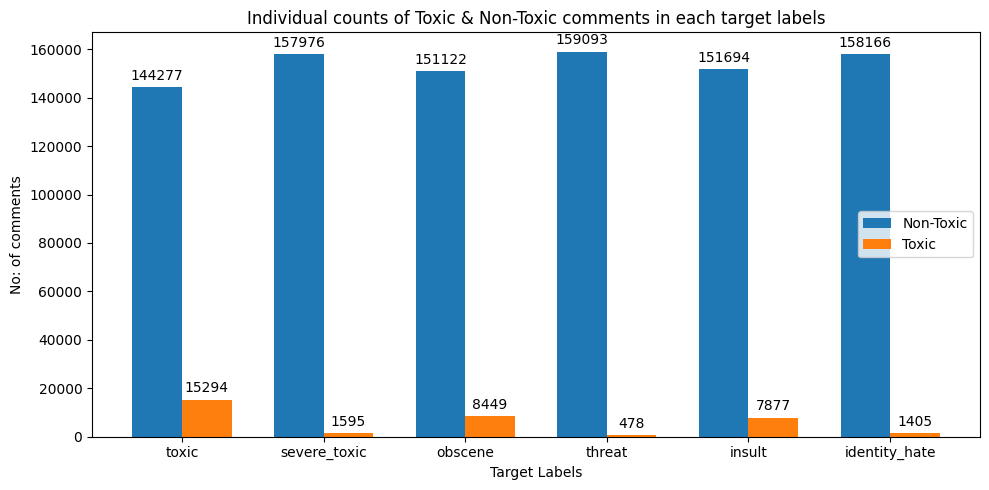

In [ ]:
# the below code is taken from official documentation of matplotlib

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

labels = df.columns.values[2:]
class_0=[]
class_1=[]

for i in df.columns.values[2:]:
    vc=df[i].value_counts()
    class_0.append(vc[0])
    class_1.append(vc[1])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, class_0, width, label='Non-Toxic')
rects2 = ax.bar(x + width/2, class_1, width, label='Toxic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No: of comments')
ax.set_xlabel("Target Labels")
ax.set_title('Individual counts of Toxic & Non-Toxic comments in each target labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=7)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.bar
fig.tight_layout()

plt.show()


Class 1 = Toxic
Class 0 = Non- Toxic

The graph above shows the data is highly imbalanced

The graph above considered  all the categories are independent:
- We counted no. of toxic and non-toxic individually
- But a comment input may belongs to more than 1 categories.

## Total values count for categories

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
# we can also do this task with use data.value_counts(),
# but the readability of the o/p is not quite hard.

# thats why i took only labels data for all the rows
#coverted numpy array with int dtype and counted unique elements using
#numpy.unique() and to present neatly,
#i created one more data frame with counts sorted in desc.

lbls=df.values[:,2:] #taking only target label data for all rows
lbls=np.array(lbls,dtype=int) #converting into numpy array
col_lbls=np.unique(lbls, return_counts=True,axis=0)
col_lbls_df=pd.DataFrame(columns=df.columns.values[2:],data=col_lbls[0])
col_lbls_df['count']=col_lbls[1]
col_lbls_df=col_lbls_df.sort_values(by=['count'],ascending=False)


print("Shape of the Collective Labels (including count-column) = ",col_lbls_df.shape)
print("\n")
col_lbls_df

Shape of the Collective Labels (including count-column) =  (41, 7)




,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
12,1,0,0,0,0,0,5666
22,1,0,1,0,1,0,3800
20,1,0,1,0,0,0,1758
14,1,0,0,0,1,0,1215
36,1,1,1,0,1,0,989
23,1,0,1,0,1,1,618
6,0,0,1,0,0,0,317
2,0,0,0,0,1,0,301
37,1,1,1,0,1,1,265


- The dataset have 6 categories of label in binary format.

1 = belongs to the particular categories

0 = does not belongs to particular categories

- Total Comments = 159,571
  Comments that does not belongs to any categories = 143,346



In [ ]:
143346/159571 * 100

89.83211235124176

- 89.83% of the dataset have no categories

In Total 16225 comments belongs to at least one of the categories.
## Visualization showing total count divided only into two categories as 'Toxic' or 'Non-Toxic'


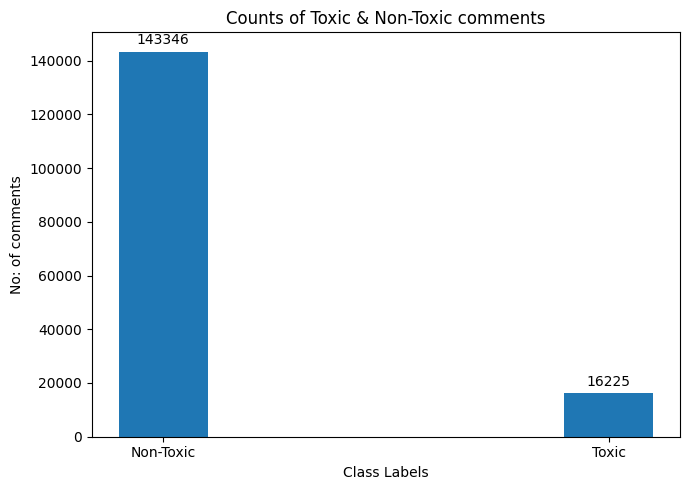

In [ ]:
#plotting toxic & non-toxic comment counts, considering from above statement
Categories=["Non-Toxic","Toxic"]
values=[0,0]

for row in col_lbls_df.values:
    if (sum(row[:-1])==0):
        values[0]=values[0]+row[-1]
    else:
        values[1]=values[1]+row[-1]

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(Categories, values, 0.2)
ax.set_ylabel('No: of comments')
ax.set_xlabel("Class Labels")
ax.set_title('Counts of Toxic & Non-Toxic comments')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()


Visualization of no. of comments that belongs to number of different categories

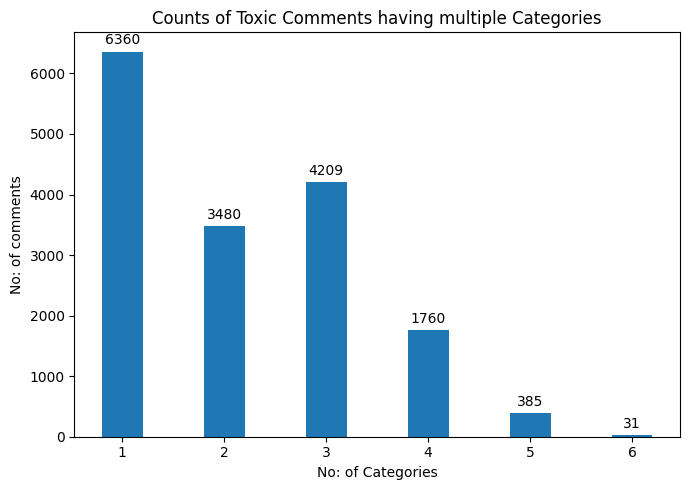

In [ ]:
no_of_possible_labels=np.arange(1,7)
values=np.zeros(6,dtype=int)

for row in col_lbls_df.values:
    if (sum(row[:-1])==1):
        values[0]=values[0]+row[-1]

    elif (sum(row[:-1])==2):
        values[1]=values[1]+row[-1]

    elif (sum(row[:-1])==3):
        values[2]=values[2]+row[-1]

    elif (sum(row[:-1])==4):
        values[3]=values[3]+row[-1]

    elif (sum(row[:-1])==5):
        values[4]=values[4]+row[-1]

    elif (sum(row[:-1])==6):
        values[5]=values[5]+row[-1]

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(no_of_possible_labels, values, 0.4)
ax.set_ylabel('No: of comments')
ax.set_xlabel("No: of Categories")
ax.set_title('Counts of Toxic Comments having multiple Categories')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()

# Venn Diagram on Target Categories Labels

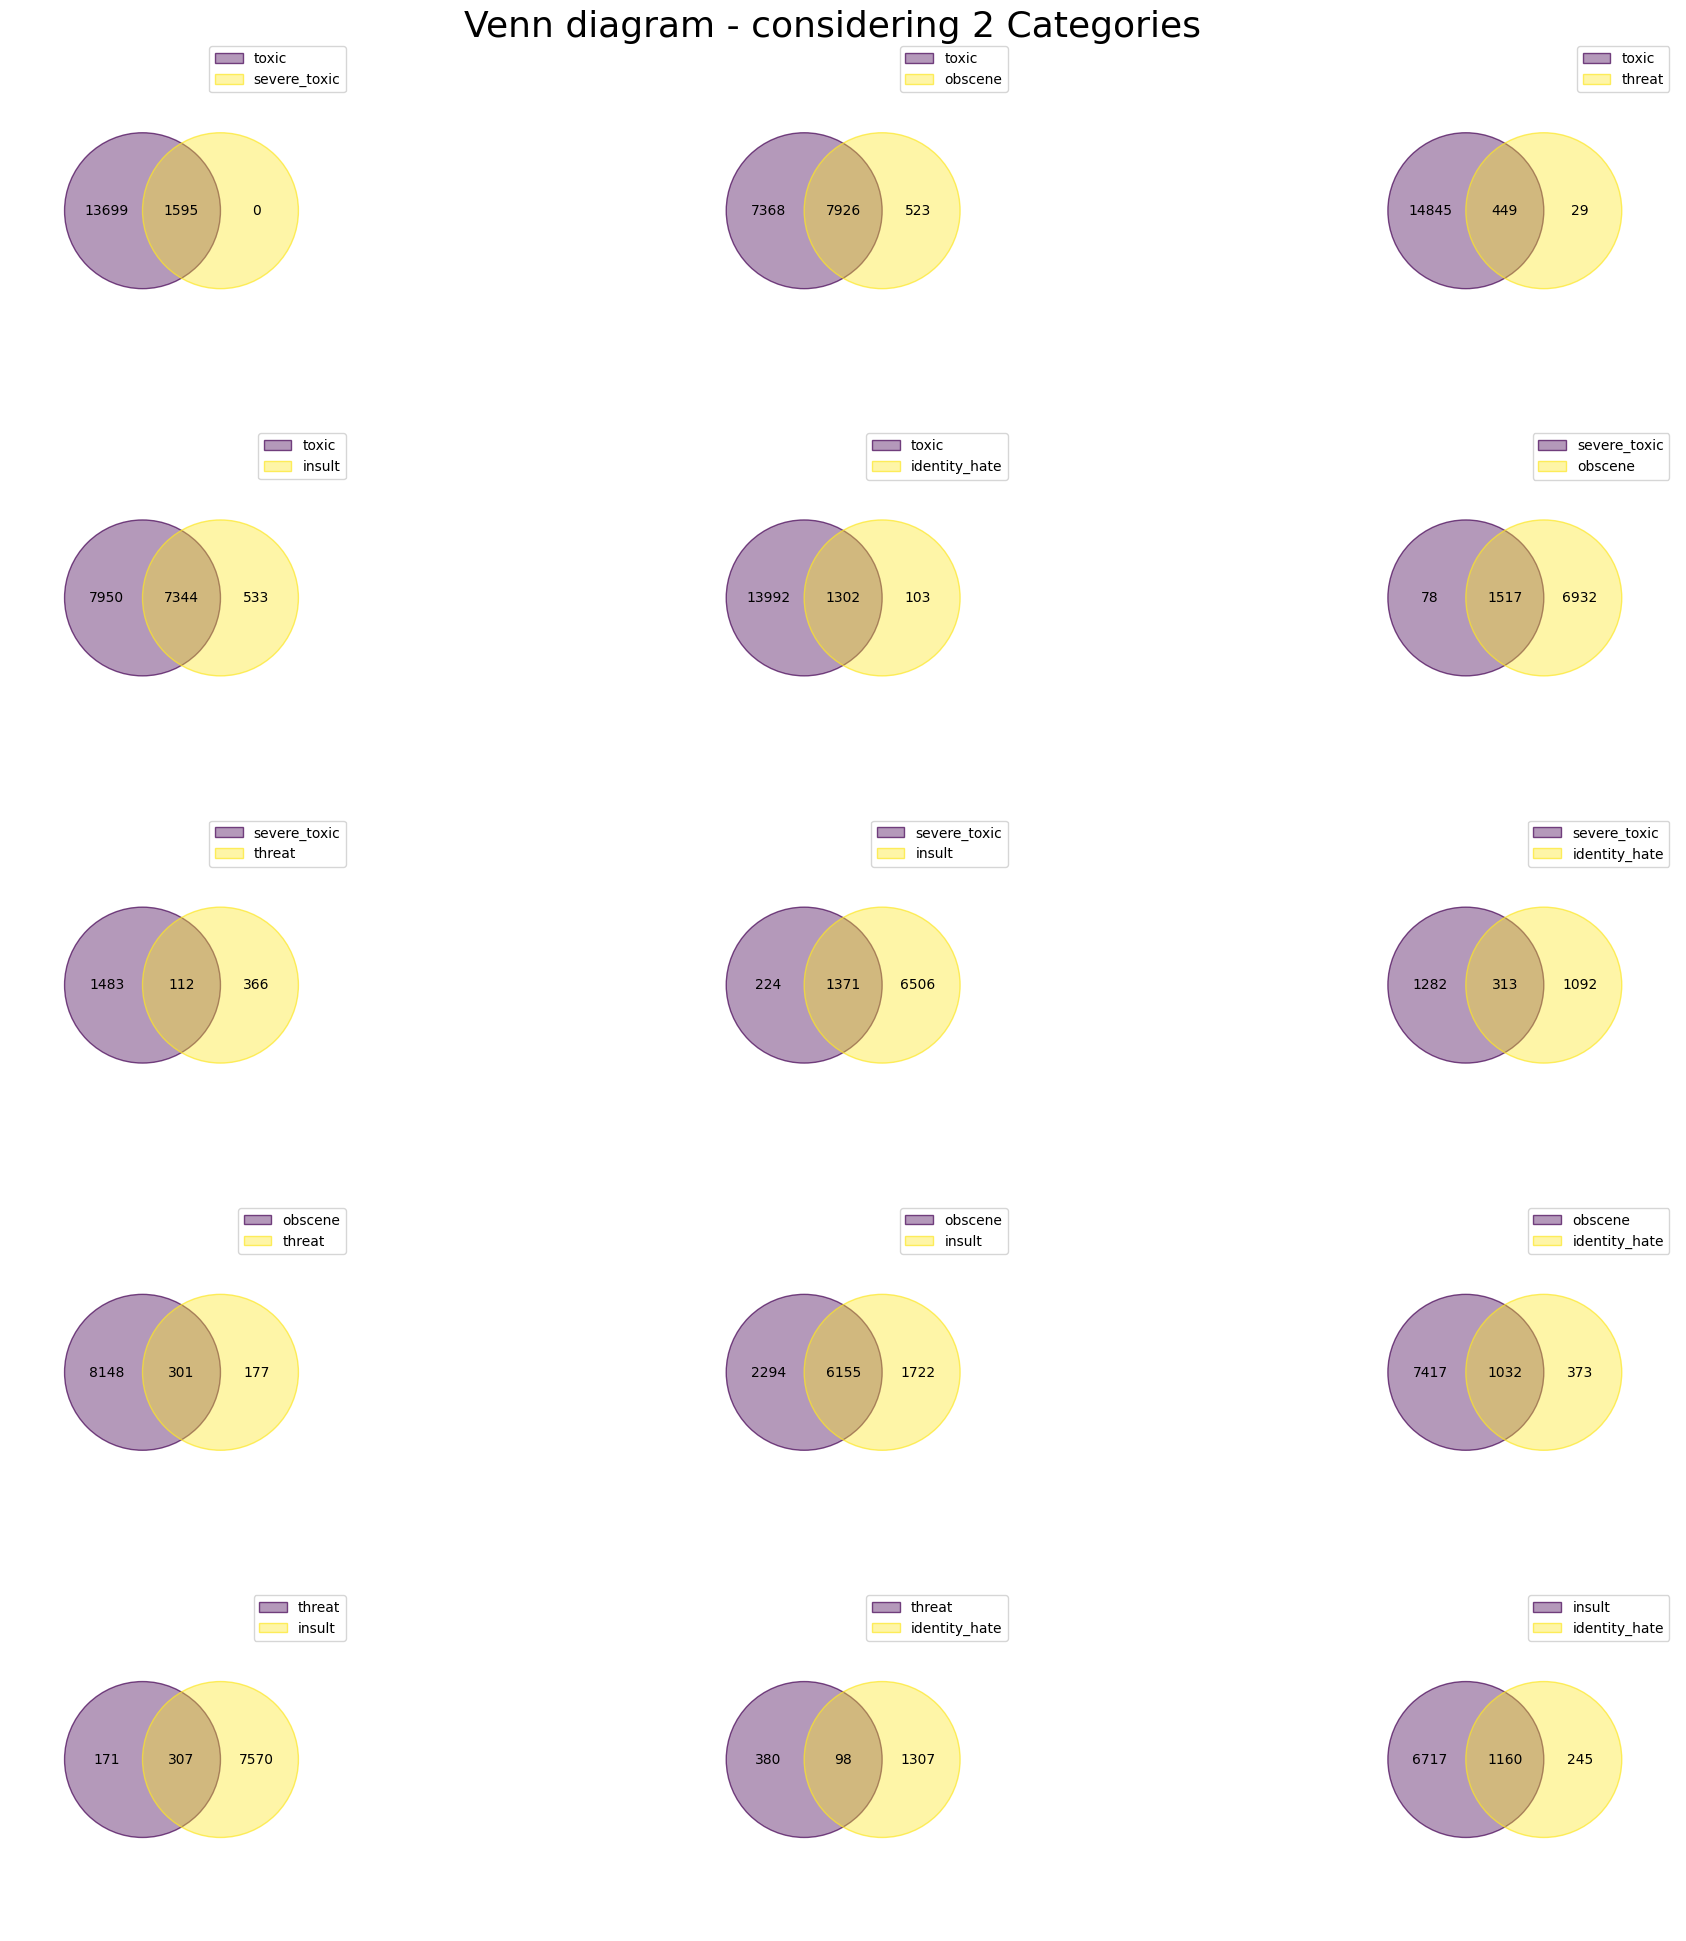

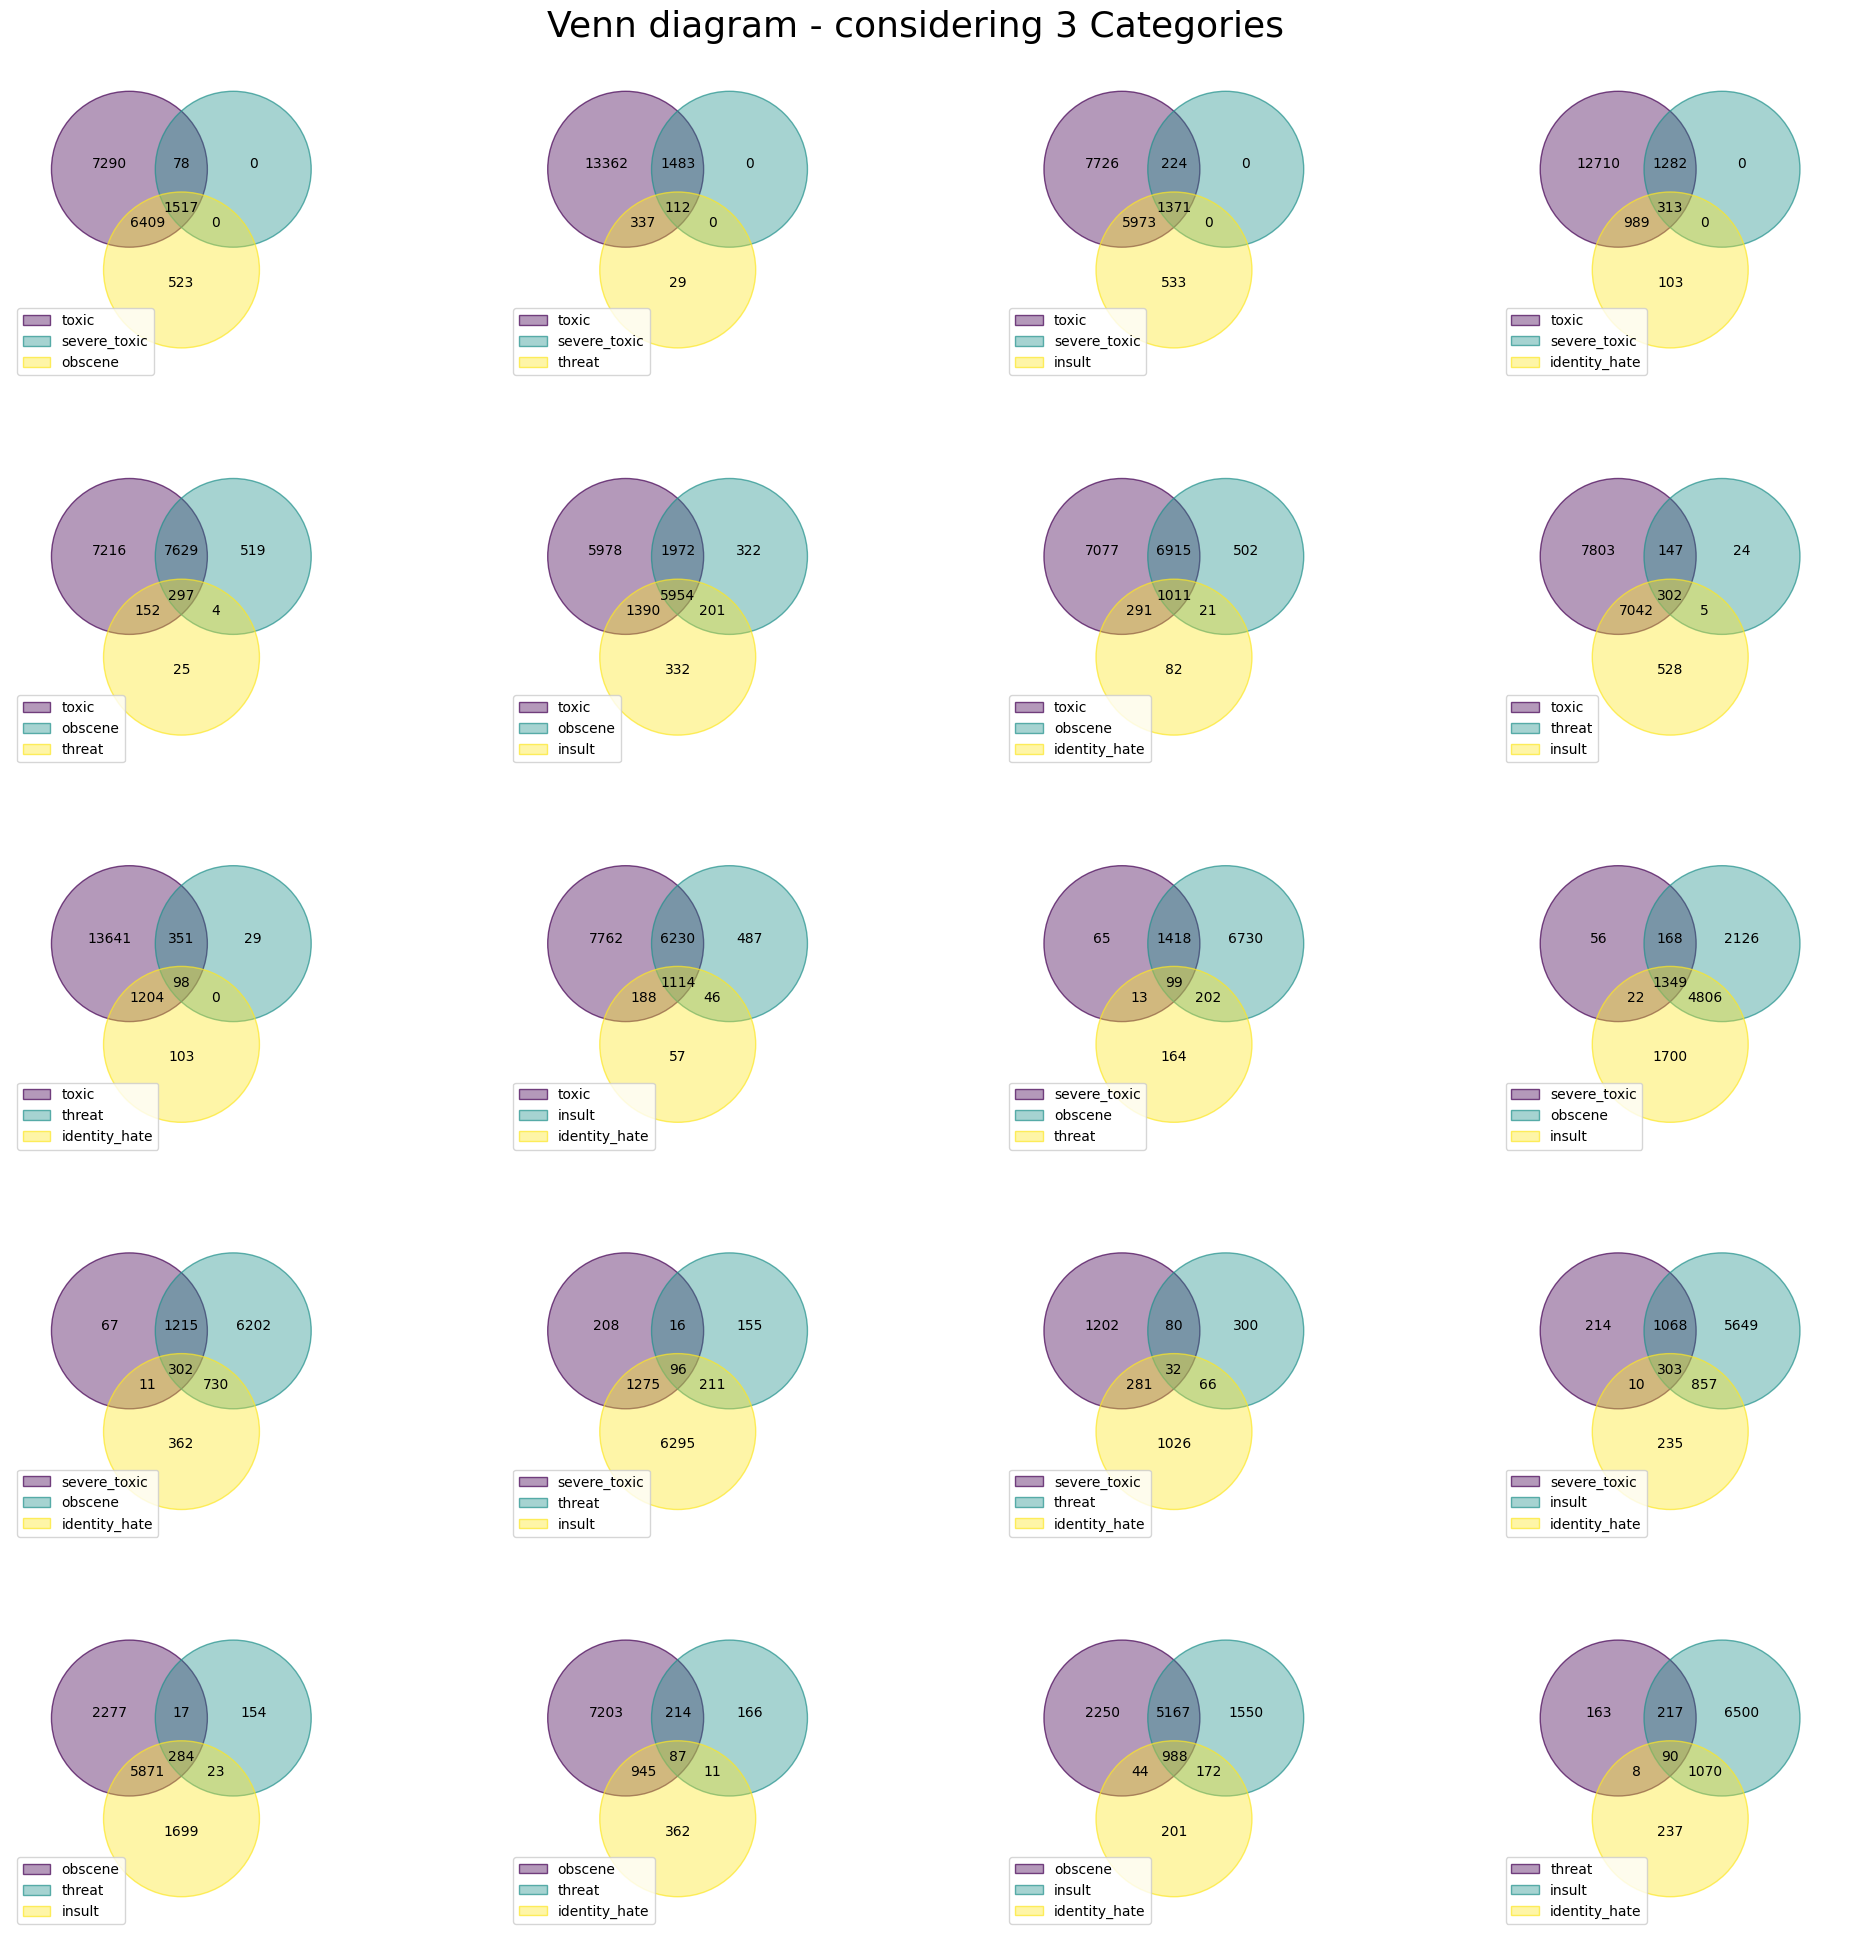

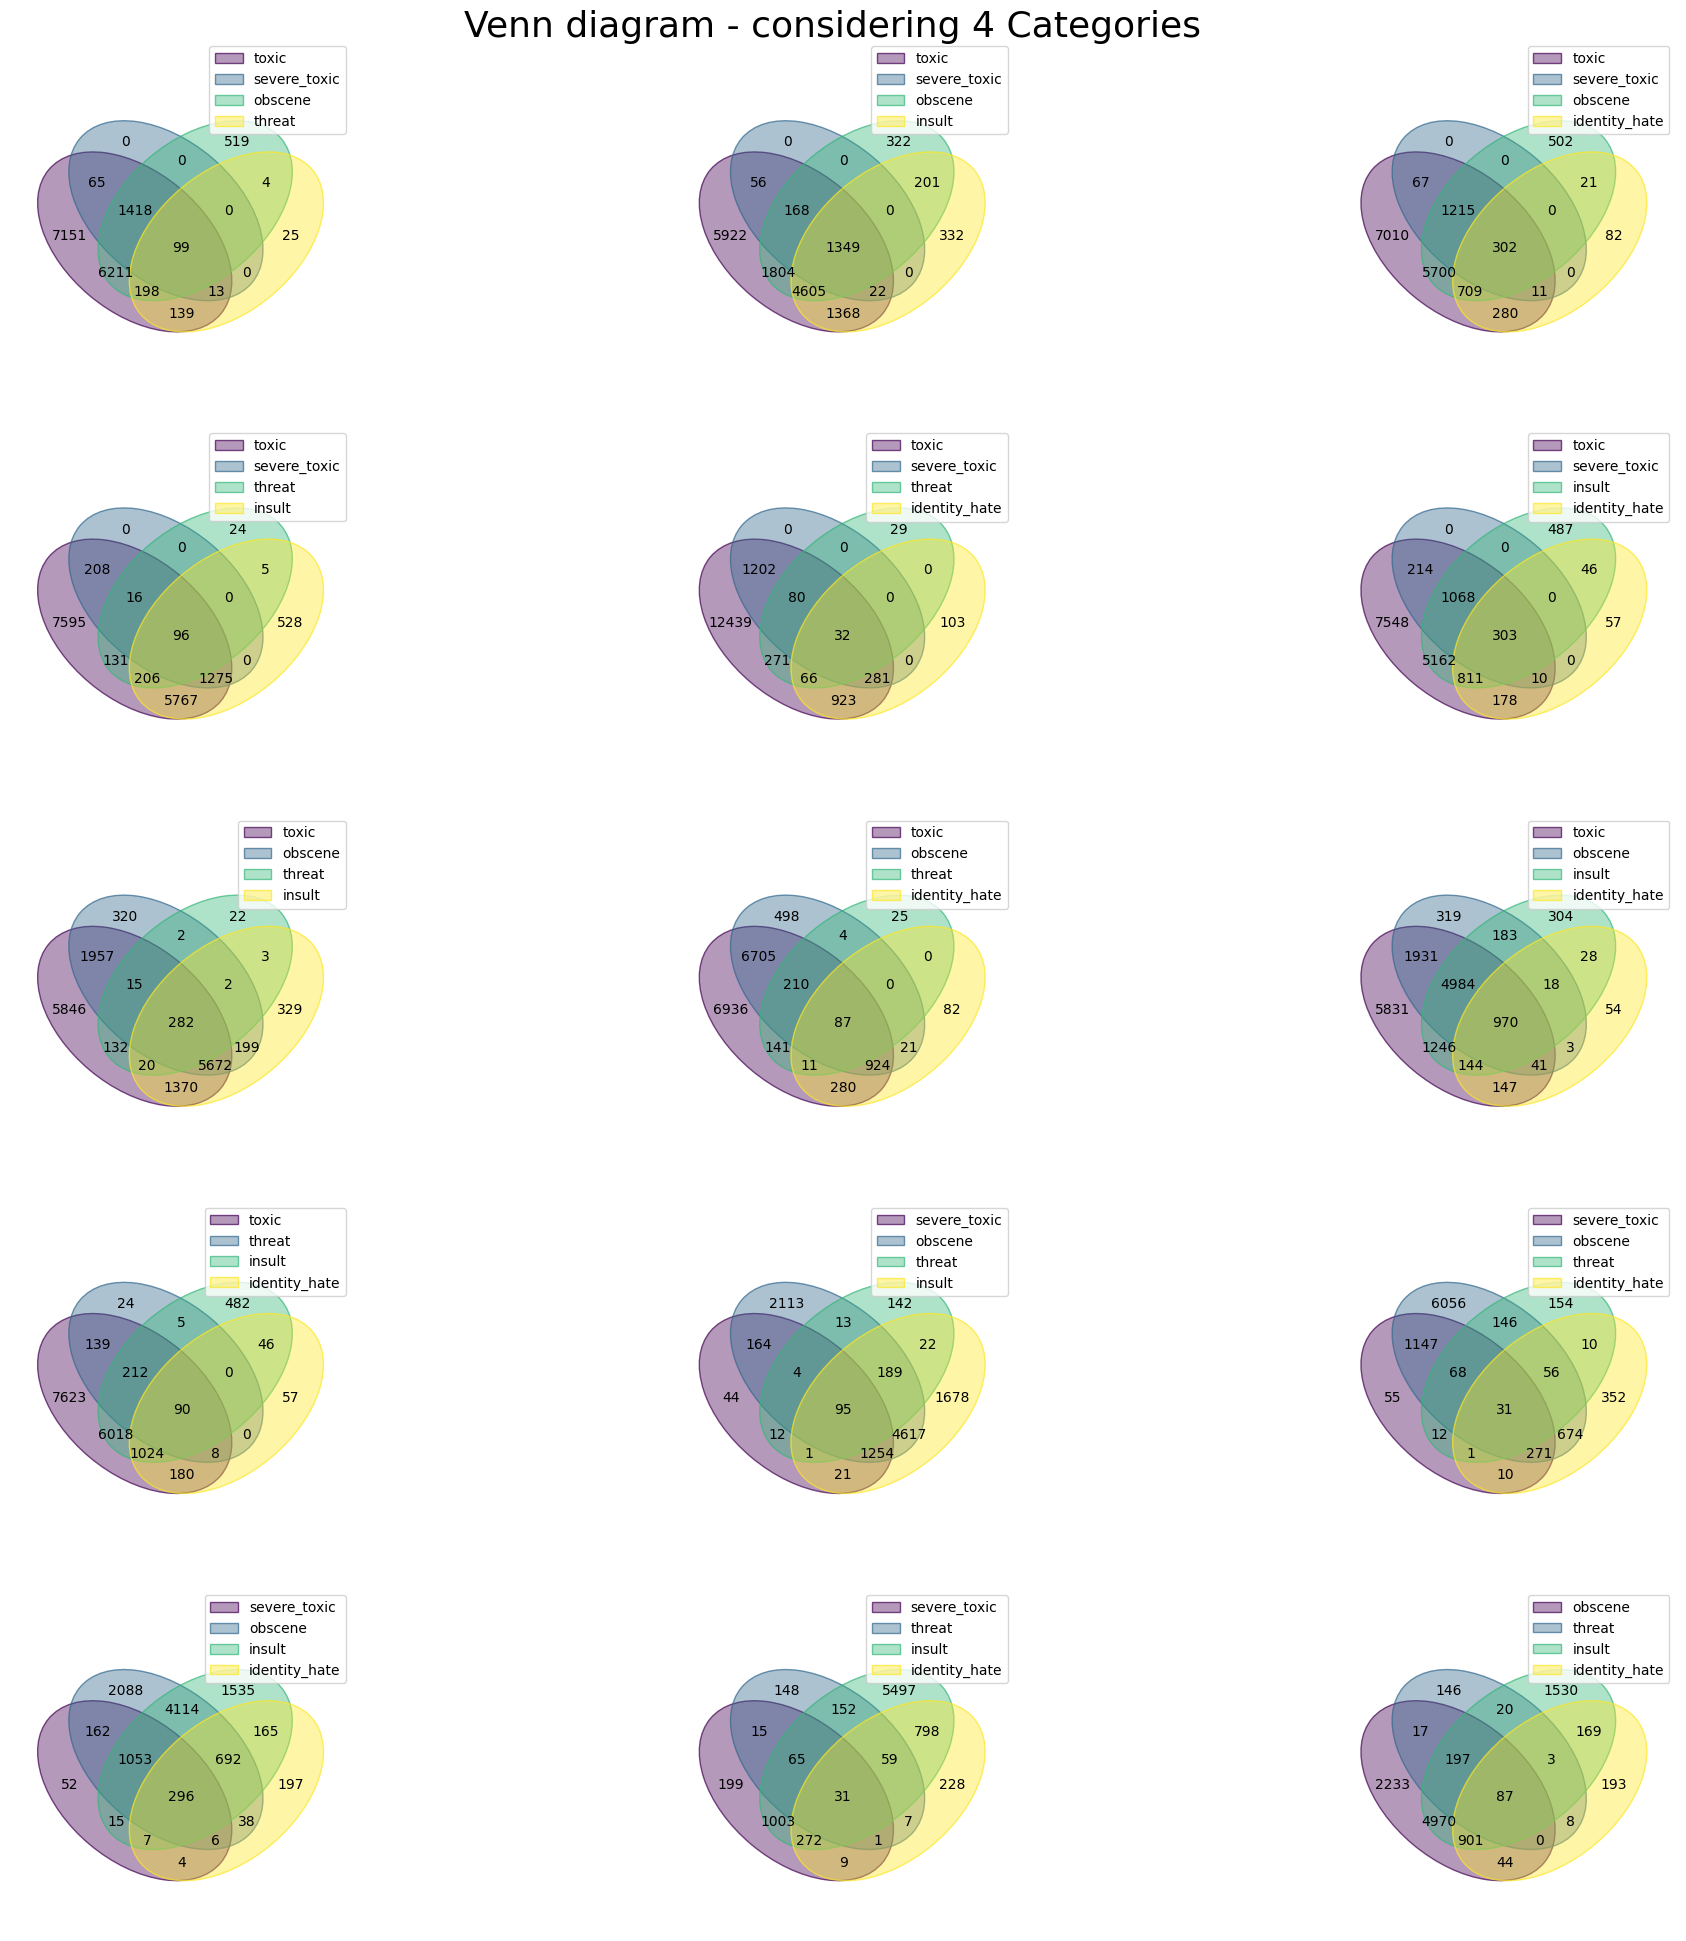

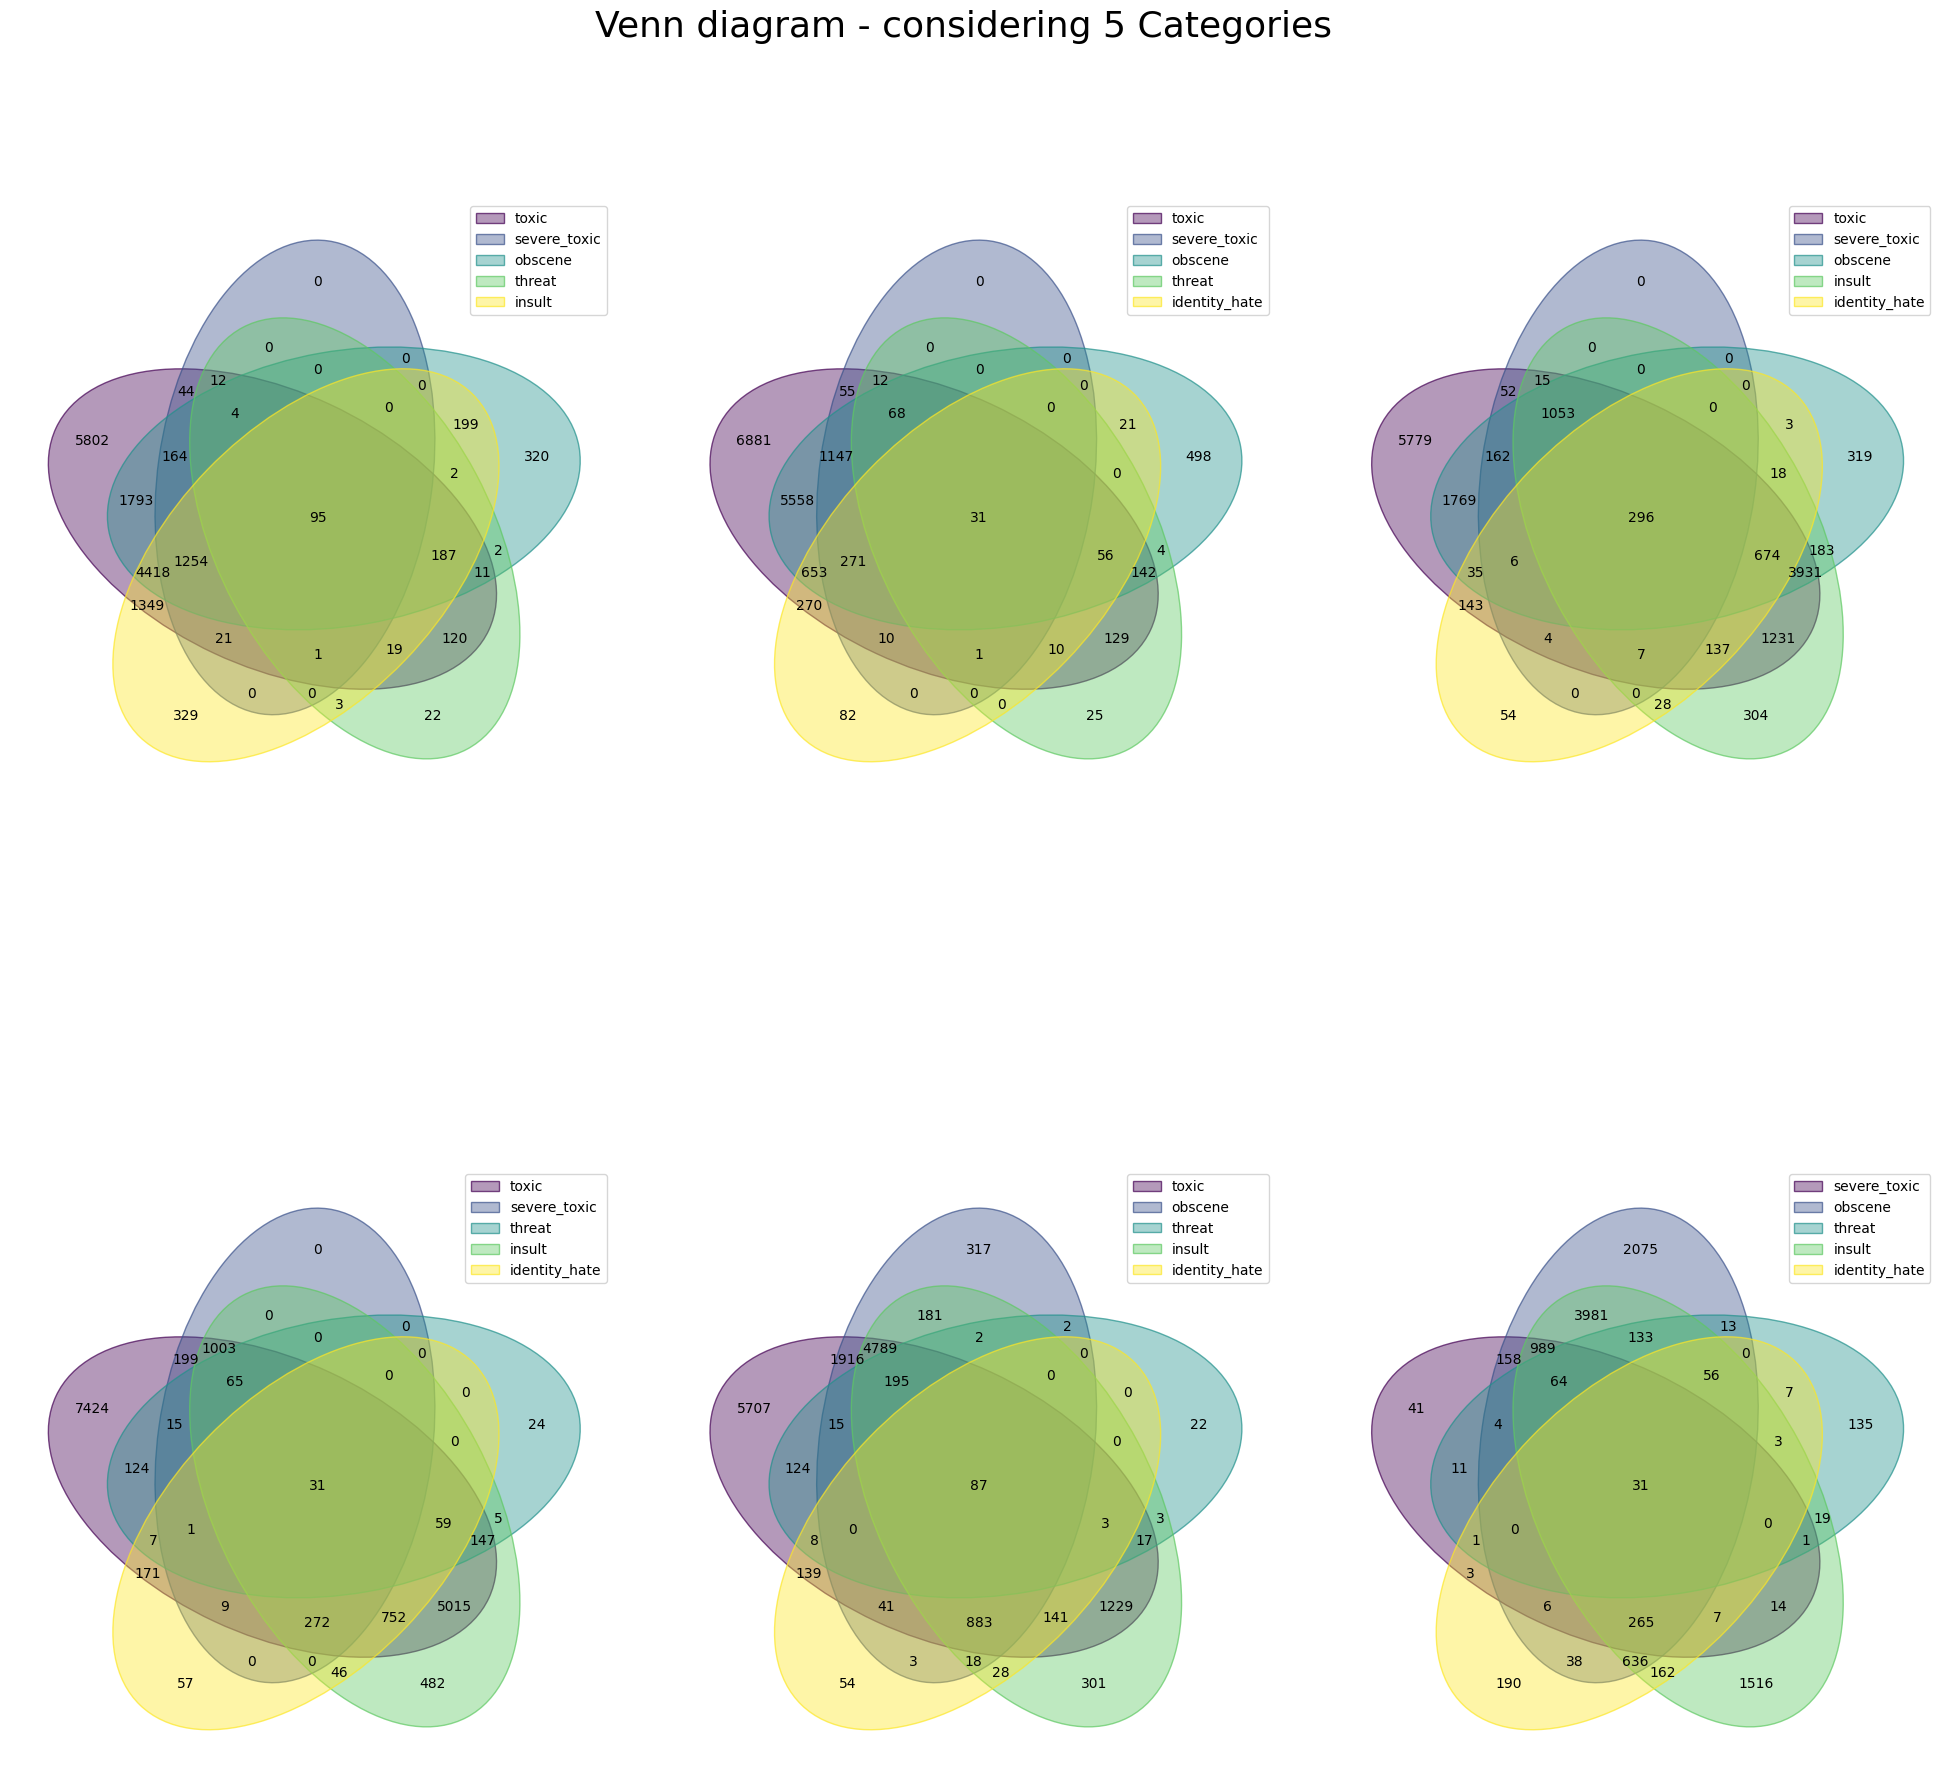

In [ ]:
no_of_labels= np.arange(2,6)
rows_col=[(5,3),(5,4),(5,3),(2,3)]


for i,rc in zip(no_of_labels,rows_col):
    comb = combinations(df.columns.values[2:], i)
    fig, top_axs = plt.subplots(ncols=rc[1], nrows=rc[0],figsize=(20, 20))
    fig.suptitle("Venn diagram - considering "+str(i)+" Categories",fontsize=26)
    fig.subplots_adjust(top=0.88)
    fig.tight_layout()
    top_axs=top_axs.flatten()
    for j,ax in zip(list(comb),top_axs):
        data_set=dict()
        for k in j:
            data_set[k]=set(df[(df[k]==1)].index)
        venn_dgrm=venn.venn(data_set,legend_loc="best",alpha=0.4,fontsize=10,ax=ax)

- All Severe_Toxic class comments are Toxic
- Most Recurring  Toxic class are Insult, Obscene.

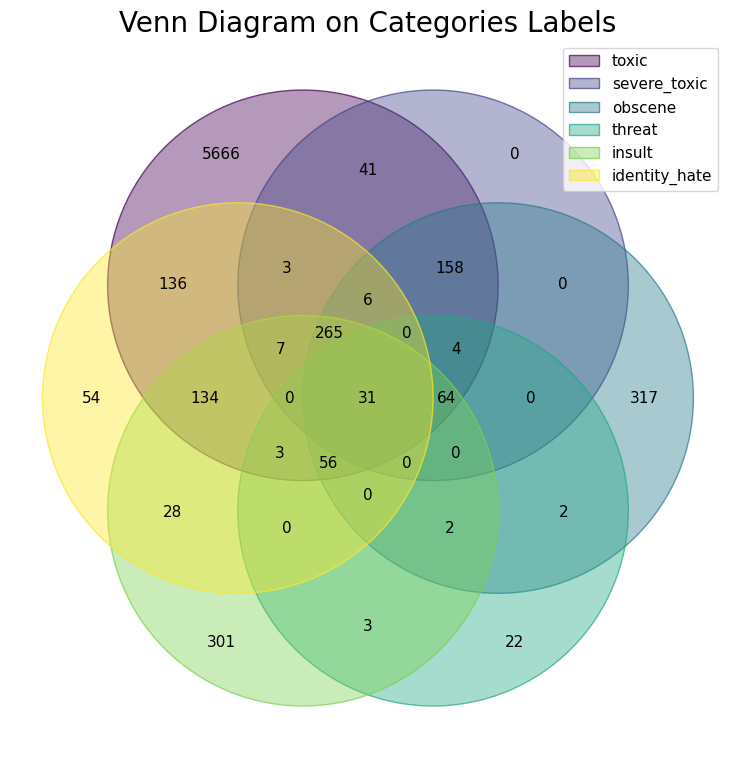

In [ ]:
#for 6 sets, by default venn.venn() draws venn diagram with triangles
#psudeovenn draws cicrle by considering only few intersections.

fig, ax = plt.subplots(figsize=(8,8))
dataset_dict = {
    col: set(df[(df[col]==1)].index)
    for col in df.columns[2:]
}
ax.set_title("Venn Diagram on Categories Labels",fontsize=20)
fig.tight_layout()
venn_dgrm=venn.pseudovenn(dataset_dict,hint_hidden=False,ax=ax,legend_loc="best",alpha=0.4,fontsize=11)

# Correlation between the different categories label:

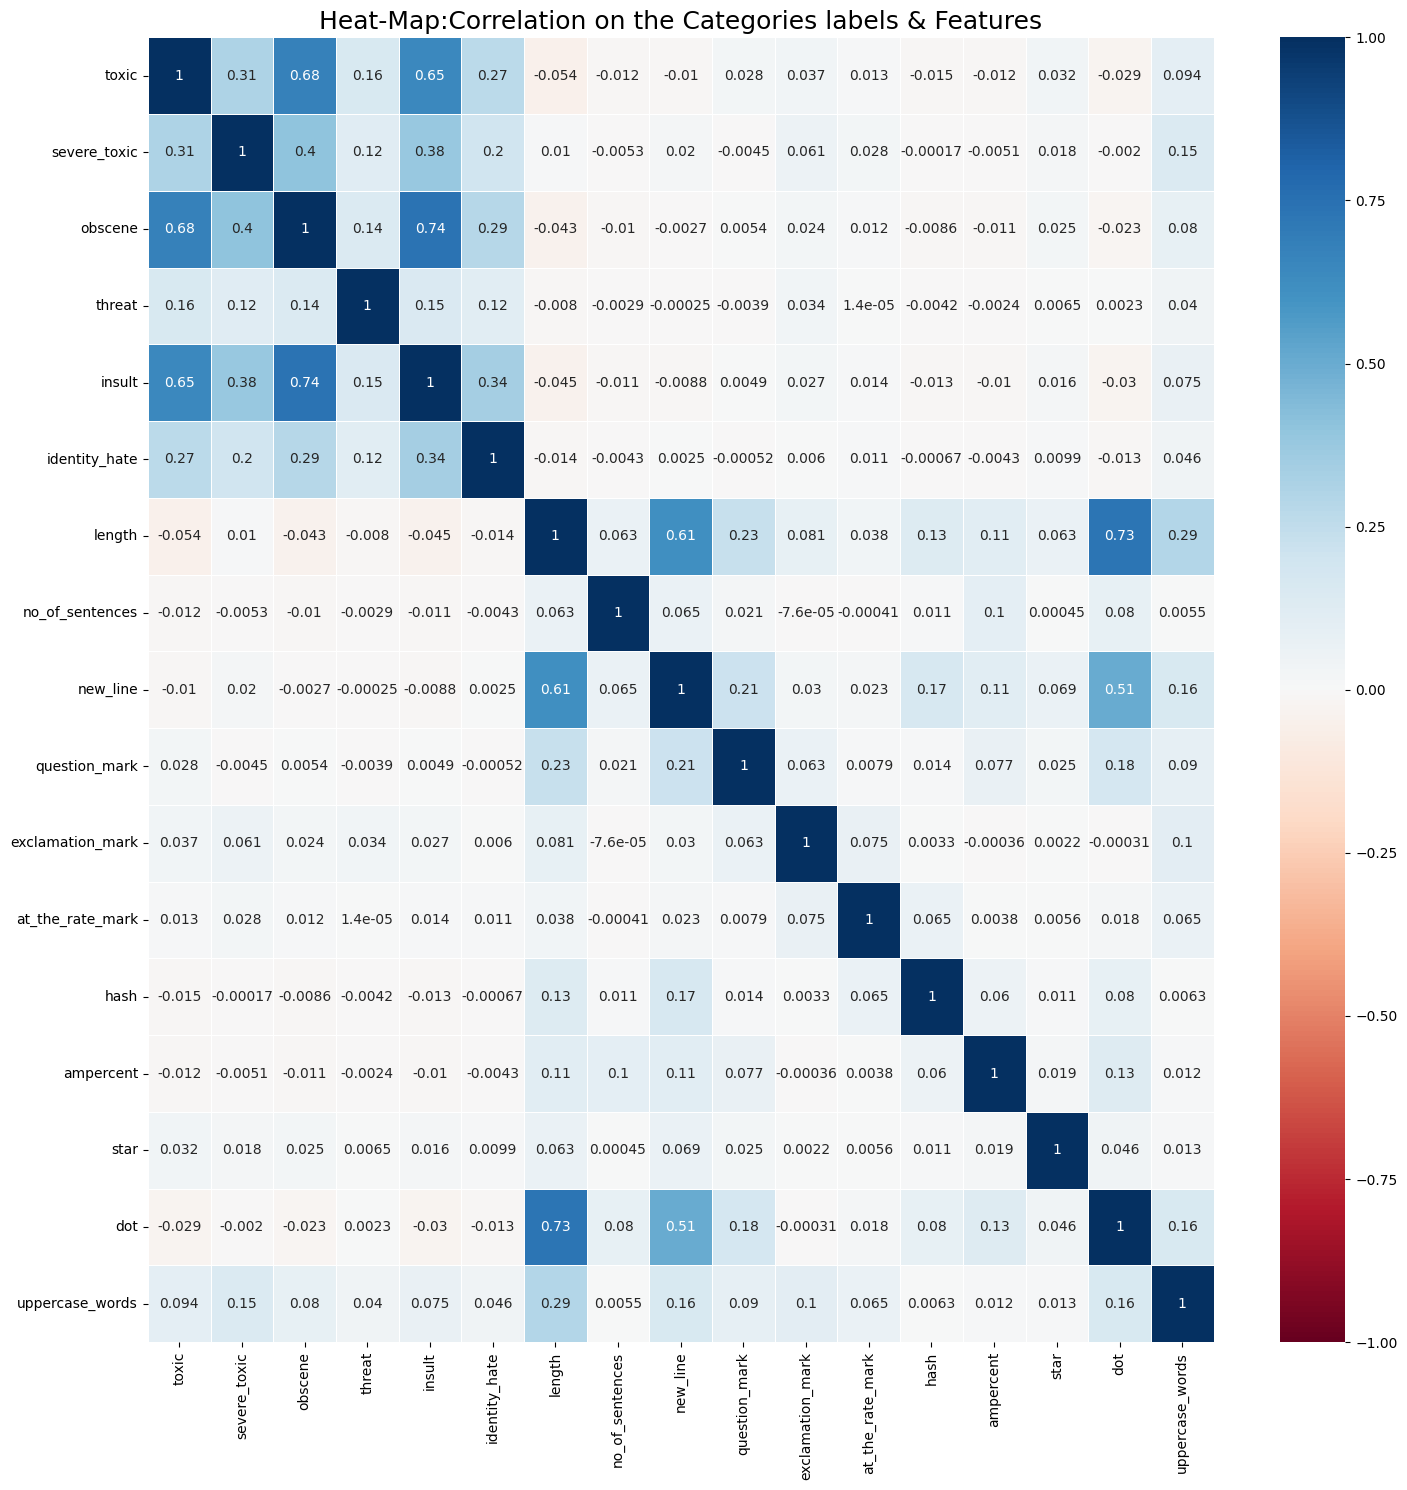

In [ ]:
corr_df=df.drop(columns=["id","comment_text"])
corr_df['length']=df['comment_text'].str.len()
corr_df['no_of_sentences']=df['comment_text'].str.split("/n").apply(len)
corr_df['new_line'] = df['comment_text'].str.count('\n')
corr_df['question_mark'] = df['comment_text'].str.count('\?')
corr_df['exclamation_mark'] = df['comment_text'].str.count('!')
corr_df['at_the_rate_mark'] = df['comment_text'].str.count('@')
corr_df['hash'] = df['comment_text'].str.count('#')
corr_df['ampercent'] = df['comment_text'].str.count('&')
corr_df['star']= df['comment_text'].str.count('\*')
corr_df['dot'] = df['comment_text'].str.count('\.')
corr_df['uppercase_words'] = df['comment_text'].str.split().apply(lambda x: sum(map(str.isupper, x)))

correlation=corr_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation,vmin=-1,cmap='RdBu',annot=True,linewidths=.5)
plt.title("Heat-Map:Correlation on the Categories labels & Features",fontsize=18)
plt.tight_layout()

# Pre Prossesing and Cleaning



In [ ]:

# Get the rows with all binary 0 from toxic to identity_hate
rows_all_zero = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

# Get the rows with at least one binary 1 from toxic to identity_hate
rows_at_least_one = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]

# Sample 15,000 rows from the rows_all_zero DataFrame
sampled_rows_all_zero = rows_all_zero.sample(n=15000, random_state=42)

# Concatenate the sampled_rows_all_zero DataFrame with the rows_at_least_one DataFrame
balanced_df = pd.concat([sampled_rows_all_zero, rows_at_least_one])

# Shuffle the rows in the balanced_df DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Print the balanced dataset
print(balanced_df)


                      id                                       comment_text  \
149613  5ead69fe1514fad8                 Fuck off!!!!- () Wolfkeeper (Talk)   
49264   83b2247a526590a0  User talk:PNG crusade bot \n\nDon't you hate m...   
95988   017416e32cda740d  Probably another station named Ridgewood. I'm ...   
90339   f1c5aace99c51a74  Next time this happens i won't just report it,...   
67069   b3727be9a9c5d2c4  New\nAccording to , a Japanese lady named Kama...   
...                  ...                                                ...   
145972  24e49a492f3d7d32  correctionperson: I corrected it not vandalize...   
27165   47dd1a90bb3ea130  "\n\n September 2009 \nHello, and welcome to W...   
97660   0a760296d10de338  Welcome!\n\nHello, , and welcome to Wikipedia!...   
7427    13bd31e6ec7dc936        DON'T YOU FUCKING TOUCH MY EDITS AGAIN!!!!!   
84447   e1de3bc842120cdf  Prior to Quickpolls, he would have been perma-...   

        toxic  severe_toxic  obscene  threat  insul

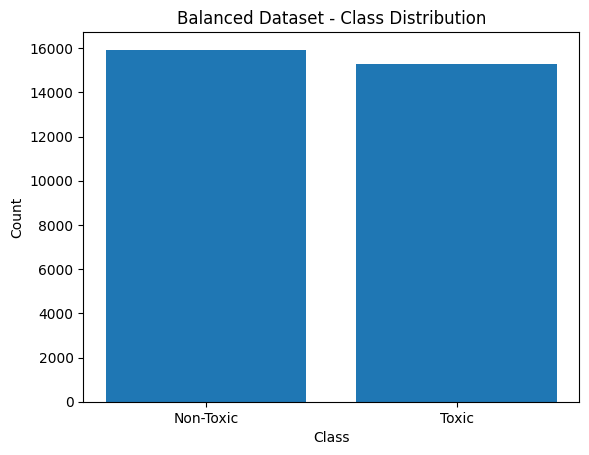

In [ ]:
# Calculate the count of each class in the balanced_df DataFrame
class_counts = balanced_df['toxic'].value_counts()

# Create a bar graph
plt.bar(class_counts.index, class_counts.values)

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Balanced Dataset - Class Distribution')

# Customize the x-axis labels
plt.xticks(class_counts.index, ['Non-Toxic', 'Toxic'])

# Show the plot
plt.show()


##Correlation Heatmap after Data Balancing and Cleaning:

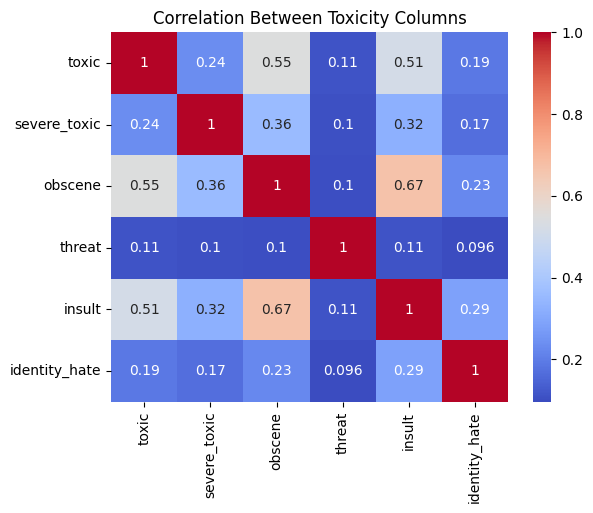

In [ ]:
import seaborn as sns

# Select the toxicity columns
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate the correlation matrix
correlation_matrix = balanced_df[toxicity_columns].corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Between Toxicity Columns')

# Show the plot
plt.show()


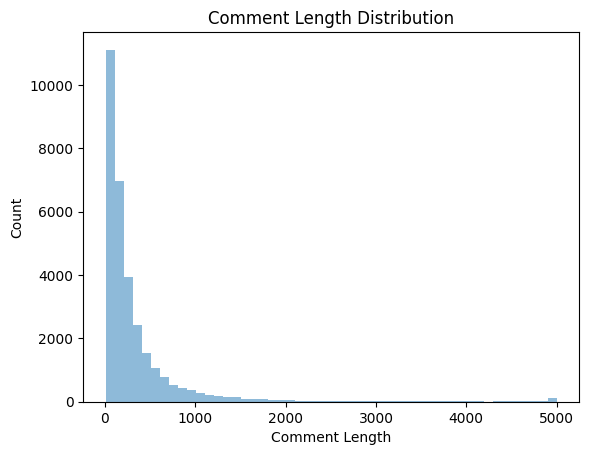

In [ ]:
import matplotlib.pyplot as plt

# Calculate the length of each comment
comment_lengths = balanced_df['comment_text'].apply(len)

# Create a histogram
plt.hist(comment_lengths, bins=50, alpha=0.5)

# Add labels and title
plt.xlabel('Comment Length')
plt.ylabel('Count')
plt.title('Comment Length Distribution')

# Show the plot
plt.show()


#Stop-Words
Stop words are words that  doesn't carry any significance  importance in classification task. ie., words which are more recurring .

In [ ]:
#supporting/essential downloads for NLTK library
#to handle chuncking/stemming/stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# printing  samples of the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
from nltk.stem.porter import PorterStemmer
port_stem = PorterStemmer()

# Pre-processing Textual Data
- Textual datas are highly unstructured
- Cleaning to be done on:
  - Stopword Removal
  - Punctuation Removal
  - Standardised the alpabets to lower case.

- Stemming - is a process of reducing a word to its Root word
example : 'programmer','programming'-->'program'
This step are applied to reduce the number of tokens to transfer the same information and therefore helps with boosting up the process of machine learning model.

In [ ]:
# Created a function for Stemming
def stemming(comment_text) :
  stemmed_content = re.sub('[^a-zA-Z]',' ', comment_text )
  stemmed_content = stemmed_content.lower() # To convert all the letters to lower case
  stemmed_content = stemmed_content.split() #
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  # The above for loop to remove stopwords and stem the words to its root words
  stemmed_content =' '.join(stemmed_content)
  return stemmed_content


In [ ]:
balanced_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
149613,5ead69fe1514fad8,fuck wolfkeep talk,1,1,1,0,1,0
49264,83b2247a526590a0,user talk png crusad bot hate mindless bot min...,0,0,0,0,0,0
95988,017416e32cda740d,probabl anoth station name ridgewood go check one,0,0,0,0,0,0
90339,f1c5aace99c51a74,next time happen report eat children rarghhhh ...,1,1,1,1,1,0
67069,b3727be9a9c5d2c4,new accord japanes ladi name kama chinen recen...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
145972,24e49a492f3d7d32,correctionperson correct vandal blood libel ac...,1,0,0,0,0,0
27165,47dd1a90bb3ea130,septemb hello welcom wikipedia hope seem unfri...,0,0,0,0,0,0
97660,0a760296d10de338,welcom hello welcom wikipedia thank contribut ...,0,0,0,0,0,0
7427,13bd31e6ec7dc936,fuck touch edit,1,0,1,0,0,0


In [ ]:
clean_data=balanced_df.drop(columns=["id"])
clean_data.sample(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
60128,england sorri bother repli first place,0,0,0,0,0,0
148384,hi hrenrut welcom wikipedia welcom wikipedia m...,0,0,0,0,0,0
121502,manag proper process correctli use absolut wro...,1,0,0,0,0,0
34020,best wish bet wish warmest greet land smile le...,0,0,0,0,0,0
37229,februari utc let forget rapist murder warmong ...,1,0,0,0,0,0


## Saving the pre-process data to .csv file

In [ ]:

clean_data.to_csv('/content/drive/MyDrive/Colab Notebooks/clean_df.csv',header=True, index=False)